# Evaluating Multi-Class Classification of Blood Cells from a Combined Image

In this project, a model is trained to classify individual blood cell images into distinct classes. Later, multiple images from different classes are combined using OpenCV to form a single composite image. The objective is to explore whether the trained model can predict multiple classes from this combined image, simulating a real-world scenario where multiple objects (in this case, blood cells of different types) appear within a single image.

### Reference

[Kaggle Notebook on White Blood Cells Classification](https://www.kaggle.com/code/masoudnickparvar/resnet50-white-blood-cells-classification).


## Importing Libraries


In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime
import cv2
import os
import io

## Data Preparation
 
1.   Load all training and testing data

2.   Initialize the training data augmentation object

3.   Split 20 percents of Training dataset into Validation set

### Data Augmentation
In order to make the most of our few training examples, we will **augment** them via a number of random transformations, so that our model would never see the same picture twice. This helps prevent **overfitting** and helps the model generalize better.

In [81]:
IMAGE_SIZE = 224
BATCH_SIZE = 32


TRAIN_PATH = "../input/white-blood-cells-dataset/Train"
TEST_PATH = "../input/white-blood-cells-dataset/Test-A"

# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)


train_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='training',batch_size = BATCH_SIZE,shuffle = True,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='validation',batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(directory = TEST_PATH,batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


## Visualize Data

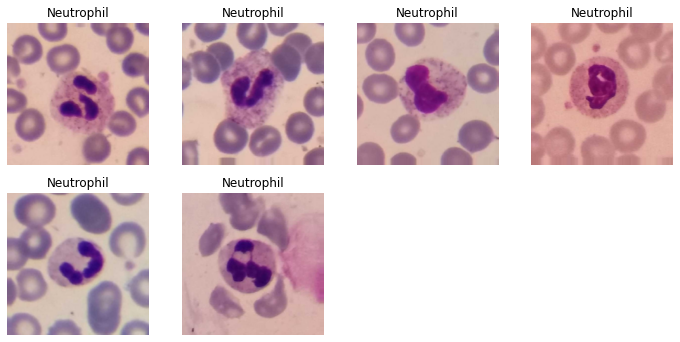

In [82]:
# plot some image of our dataset
import matplotlib.pyplot as plt
import numpy as np

labels = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte','Neutrophil']

image,label = train_gen.next()

plt.figure(figsize = (12,12))
for i in range(6) :
    plt.subplot(4, 4, i+1)
    plt.imshow(image[i])
    plt.title(labels[np.argmax(label[i])])
    plt.axis('off')
plt.show()

## Fine Tuning
Fine tuning consists of unfreezing the entire model we obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.

In this project, We'll be using the **ResNet50** model which will use the weights from the **ImageNet** dataset.




**Note**

Setting `include_top` to `False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training

In [83]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

# net.trainable = False

**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neighbouring neurons. It helps in avoiding overfitting. Neurons to be omitted are selected at random. The rate parameter is the likelihood of a neuron activation being set to 0, thus dropping out the neuron.

**Dense** -> This is the output layer which classifies the image into one of the 5 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [84]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)
model = Dropout(0.2)(model)
model = Dense(5, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Fitting Model

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL]

history = model.fit(train_gen,validation_data = valid_gen,epochs = EPOCHS,callbacks = callbacks)

## Learning curves

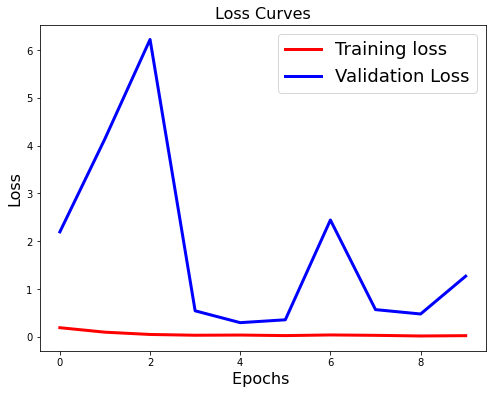

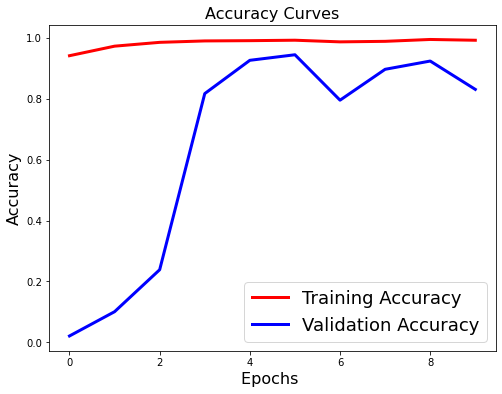

In [74]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Evaluation Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.82      0.99      0.90       322
           2       0.98      0.99      0.98      1034
           3       0.97      0.83      0.90       234
           4       0.99      0.98      0.99      2660

    accuracy                           0.97      4339
   macro avg       0.95      0.96      0.95      4339
weighted avg       0.98      0.97      0.97      4339



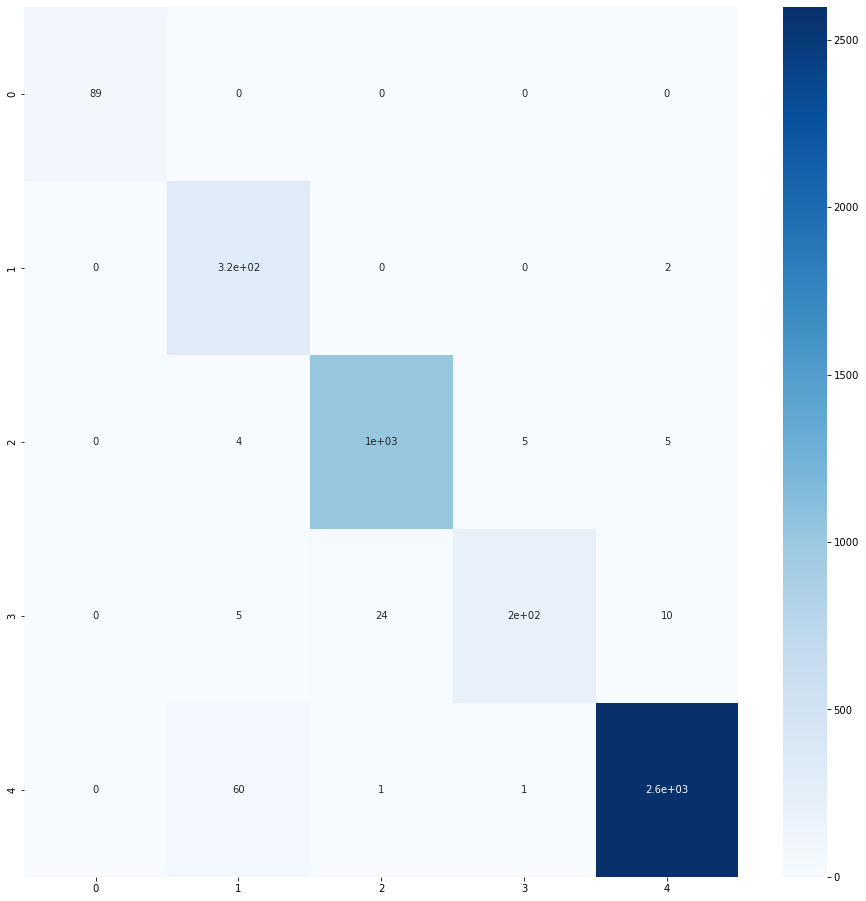

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predicted_classes = np.argmax(model.predict(test_gen), axis = 1)

confusionmatrix = confusion_matrix(test_gen.classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(test_gen.classes, predicted_classes))

## Testing Loss & Accuracy

In [76]:
loss,acc = model.evaluate(test_gen)

136/136 [==============================] - 25s 182ms/step - loss: 0.0844 - accuracy: 0.9730


## Multi-Class Prediction from a Combined Image

In [77]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=TEST_PATH,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Enable shuffling for diversity
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)


Found 4339 images belonging to 5 classes.


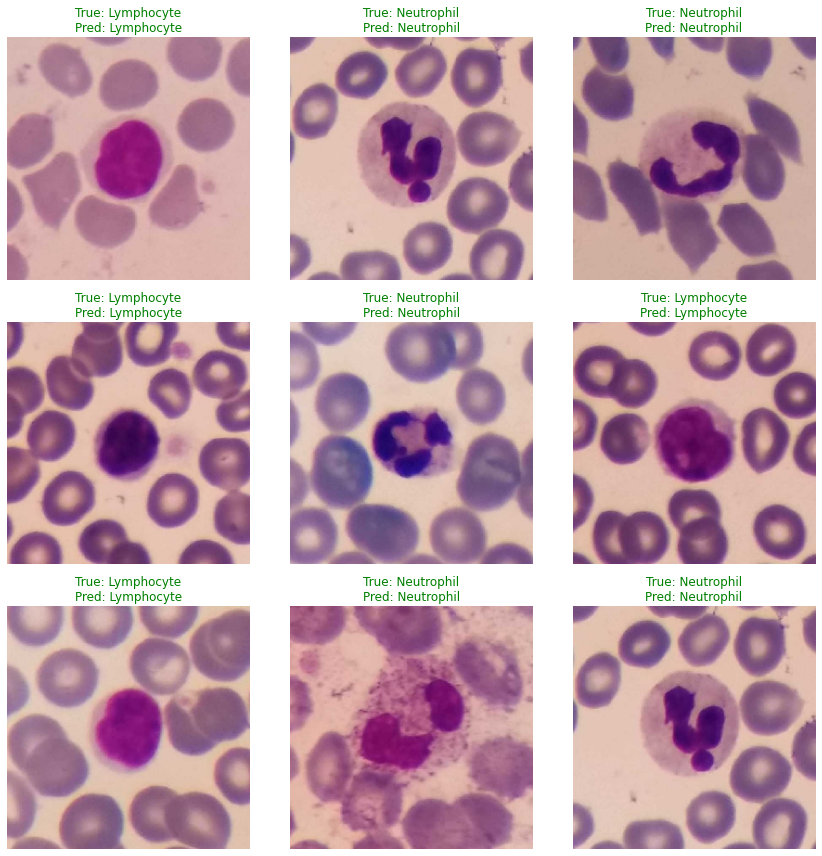

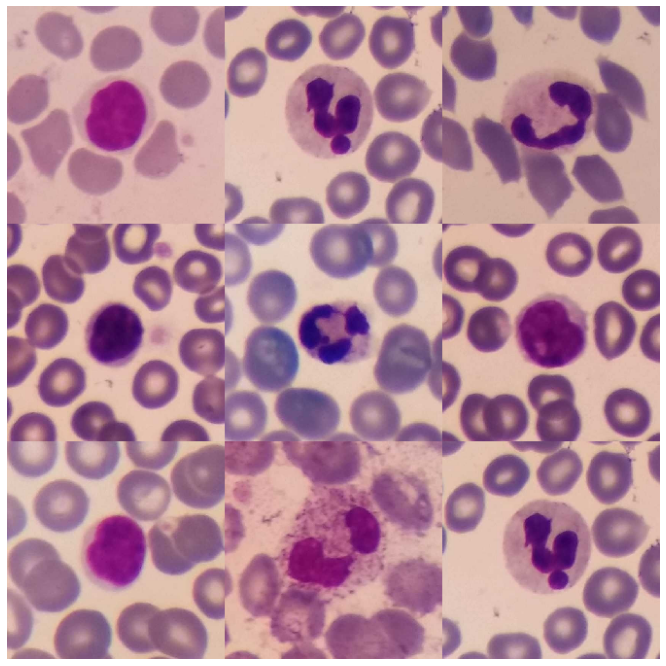

In [78]:
import random

# Labels from the dataset
labels = list(test_gen.class_indices.keys())

# Randomly pick images from the test dataset
images, true_labels = test_gen.next()
num_images_to_display = 9  # Number of images to display (3x3 grid)

# Initialize lists for labeled and unlabeled images
image_sections_with_labels = []
image_sections_without_labels = []

# Create the plot for labeled combined image
plt.figure(figsize=(12, 12))

for i in range(num_images_to_display):
    random_idx = random.randint(0, len(images) - 1)  # Randomly select an index
    img = images[random_idx]
    true_label = labels[np.argmax(true_labels[random_idx])]  # True label
    predicted_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]  # Predicted label
    
    # Add the unlabeled image to the sections
    img_resized = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    img_resized = cv2.resize(img_resized, (224, 224))  # Resize to IMAGE_SIZE
    image_sections_without_labels.append(img_resized)
    
    # Display image with labels in the grid
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(
        f"True: {true_label}\nPred: {predicted_label}",
        color="green" if true_label == predicted_label else "red"
    )
    plt.axis('off')

# Save the labeled combined image
plt.tight_layout()
plt.savefig('combined_image_with_labels.jpg')
plt.show()

# Combine the unlabeled images into a 3x3 grid
combined_image_without_labels = np.vstack([np.hstack(image_sections_without_labels[i:i+3]) for i in range(0, len(image_sections_without_labels), 3)])

# Save the unlabeled combined image
cv2.imwrite('combined_image_without_labels.jpg', combined_image_without_labels)

# Display the unlabeled combined image
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(combined_image_without_labels, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [79]:
# Load the combined image (without labels)
combined_image = cv2.imread('combined_image_without_labels.jpg')

# Preprocess the combined image for the model
combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
combined_image_resized = cv2.resize(combined_image_rgb, (224, 224))  # Resize to match model input size
combined_image_rescaled = combined_image_resized / 255.0  # Rescale pixel values to [0, 1]
combined_image_expanded = np.expand_dims(combined_image_rescaled, axis=0)  # Add batch dimension

# Predict probabilities for each class
predictions = model.predict(combined_image_expanded)[0]

# Set a threshold to determine which classes are present
threshold = 0.1  # Adjust this value as needed
predicted_classes = [labels[i] for i, prob in enumerate(predictions) if prob > threshold]

# Print the predicted classes
print("Predicted Classes in the Combined Image:")
if predicted_classes:
    for cls in predicted_classes:
        print(cls)
else:
    print("No classes detected above the threshold.")

Predicted Classes in the Combined Image:
Eosinophil
Lymphocyte
